In [1]:
# requirements
!pip install --upgrade pip
!pip install --upgrade pandas scikit-learn
!pip install --upgrade xgboost

     |████████████████████████████████| 9.7 MB 10.6 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4


## 1.1. Importanción de librerias

In [2]:
import os, types
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from botocore.client import Config
import ibm_boto3
import logging

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [3]:
# create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [4]:
RANDOM_STATE = 288

## 1.3. Carga de datos

In [5]:
# Carga de datos
df = pd.read_csv('../src/data/ds_job.csv')
df.set_index('empleado_id', inplace=True)

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_1e52a7ab76914f51815f3bc4beaef35b = 'https://s3.eu-geo.objectstorage.softlayer.net'
else:
    endpoint_1e52a7ab76914f51815f3bc4beaef35b = 'https://s3.eu-geo.objectstorage.service.networklayer.com'

client_1e52a7ab76914f51815f3bc4beaef35b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='-WrN4cg5gACPjvar-fZ3FgZcWI9-TmoM-GjkXmr23kiU',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_1e52a7ab76914f51815f3bc4beaef35b)

body = client_1e52a7ab76914f51815f3bc4beaef35b.get_object(Bucket='tfmue-donotdelete-pr-wyxiulc08c8m9b',Key='ds_job.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object

def __iter__(self): 
    return 0

if not hasattr(body, "__iter__"): 
    body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.set_index('empleado_id', inplace=True)

In [6]:
# División de los datos en train y set
X, y = df.drop('target', axis=1), df['target']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15326, 12), (15326,), (3832, 12), (3832,))

In [8]:
class BaseTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    

class OutliersTransformer(BaseTransformer):
    def __init__(self, method='drop', factor=1.5, exclude_cols=None):
        self.method = method
        self.factor = factor
        self.exclude_cols = exclude_cols
        
    def _outlier_removal(self,X,y=None):
        X = pd.Series(X).copy()
        if X.name not in self.exclude_cols:
            q1 = X.quantile(0.25)
            q3 = X.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - (self.factor * iqr)
            upper_bound = q3 + (self.factor * iqr)
            X.loc[((X < lower_bound) | (X > upper_bound))] = np.nan 
        return pd.Series(X)
    
    def _outlier_cap(self,X,y=None):
        X = pd.Series(X).copy()
        if X.name not in self.exclude_cols:
            q1 = X.quantile(0.25)
            q3 = X.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - (self.factor * iqr)
            upper_bound = q3 + (self.factor * iqr)
            X.loc[X < lower_bound] = lower_bound
            X.loc[X > upper_bound] = upper_bound
        return pd.Series(X)
    
    def fit(self,X,y=None):
        self.exclude_cols = set(self.exclude_cols) if self.exclude_cols else set()
        return self
    
    def transform(self,X,y=None):
        if self.method == 'drop':
            return X.apply(self._outlier_removal)
        elif self.method == 'cap':
            return X.apply(self._outlier_cap)
        else:
            return X
        
        
class Preprocessor(BaseTransformer):
    
    NUM_COLS = {'horas_formacion', 'indice_desarrollo_ciudad'}
    CAT_COLS = {
        'ultimo_nuevo_trabajo', 'tamano_compania', 'experiencia', 'educacion', 
        'universidad_matriculado', 'nivel_educacion', 'genero', 'ciudad'
    }
    
    def __init__(self, cols=None, transformer=ColumnTransformer(transformers=[
            # Workaround to enable pipelines parameters in gridsearchcv 
            ('num', Pipeline(steps=[
                    ('outliers', OutliersTransformer()),
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', MinMaxScaler())
                ]), []),
            ('cat', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
                ]), [])
            ])):
        
        self.cols = cols
        self.transformer = transformer
        self.categorical = []
        self.numerical = []
        self.numeric_tf = None
        self.categorical_tf = None
        
        
    def _fit(self):
        self.cols = self.cols or tuple(self.NUM_COLS | self.CAT_COLS)
        if self.cols:
            for col in self.cols:
                if col in self.CAT_COLS:
                    self.categorical.append(col)
                elif col in self.NUM_COLS:
                    self.numerical.append(col)
            
            if self.numerical:
                self.numeric_tf = Pipeline(steps=[
                    ('outliers', OutliersTransformer()),
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', MinMaxScaler())
                ])

            if self.categorical:
                self.categorical_tf = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
                ])
                
        transformers = []
        if self.numeric_tf:
            transformers.append(('num', self.numeric_tf, self.numerical))
        if self.categorical_tf:
            transformers.append(('cat', self.categorical_tf, self.categorical))
        
        self.transformer = ColumnTransformer(transformers=transformers)
    
    def fit(self, X, y=None):
        self._fit()
        self.column_transformer.fit(X, y)
        return self
    
    def transform(self, X):
        if not self.transformer:
            return X
        return self.transformer.transform(X)
    
    def fit_transform(self, X, y=None):
        self._fit()
        return self.transformer.fit_transform(X, y)
    

In [9]:
all_cols = tuple(X_train.columns.values)
pca = PCA()
X_preprocessed = pd.DataFrame(Preprocessor(cols=all_cols).fit_transform(X_train))

<AxesSubplot:xlabel='n_components'>

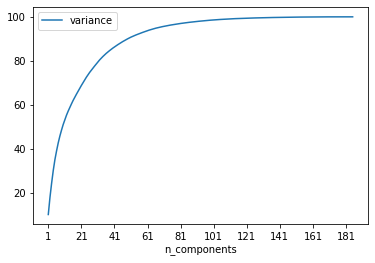

In [10]:
pca.fit(X_preprocessed)
pd.DataFrame({
    'n_components': range(1, len(X_preprocessed.columns) + 1),
    'variance': np.cumsum(pca.explained_variance_ratio_)*100         
    }).set_index('n_components').plot(xticks=range(1, X_preprocessed.shape[1], 20))

In [11]:
X_preprocessed.shape[1]

185

Observamos que la dimensionalidad puede llegar a 185 usando todas las columnas, pero que aplicando un PCA de 40 features tendriamos aún más del 80% de varianza explicada

In [12]:
class Clf(BaseEstimator):
    """Base model used to host classifiers on GridSearchCV"""
    def __init__(self, estimator=DummyClassifier()):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

Estos seran todos los parámetros disponibles en el gridsearchcv (además de los propios del estimator escogido):

In [13]:
make_pipeline(Preprocessor(), PCA(), Clf()).get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()), ('pca', PCA()), ('clf', Clf())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'pca': PCA(),
 'clf': Clf(),
 'preprocessor__cols': None,
 'preprocessor__transformer__n_jobs': None,
 'preprocessor__transformer__remainder': 'drop',
 'preprocessor__transformer__sparse_threshold': 0.3,
 'preprocessor__transformer__transformer_weights': None,
 'preprocessor__transformer__transformers': [('num',
   Pipeline(steps=[('outliers', OutliersTransformer()),
                   ('imputer', SimpleImputer(strategy='median')),
                   ('scaler', MinMaxScaler())]),
   []),
  ('cat',
   Pipeline(steps=[('imputer',
                    SimpleImputer(fill_value='missing', strategy='constant')),
                   ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))]),
   [])],
 'preprocessor__transformer__verbose': False,
 'preprocessor__transformer__num': Pipeline(steps=[('outliers', OutliersTransformer()),
            

## Backward Feature Selection 

### Iteración 1

Hayamos todas las combinaciones posibles de columnas:

In [14]:
comb = [itertools.combinations(all_cols, x) for x in range(1, len(all_cols)+1)]
len(list(itertools.chain.from_iterable(comb)))

4095

Se pueden formar 4095 combinaciones de columnas, vamos a quedarnos con las combinaciónes que tengan más de 10 variables

In [15]:
comb = [itertools.combinations(all_cols, x) for x in range(11, len(all_cols)+1)]
col_comb = list(itertools.chain.from_iterable(comb))
len(col_comb)

13

A partir de aquí podemos probar todas las posibles combinaciones de columnas con todos los preprocesados y modelos que queramos

In [16]:
param_grid = {
    'preprocessor__cols': col_comb,
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': [None, 'cap', 'drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler(), StandardScaler()],
    'preprocessor__transformer__num__imputer': [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean')],
    'preprocessor__transformer__cat__imputer': [
        SimpleImputer(strategy='constant', fill_value='missing'), 
        BaseTransformer()], # BaseTransformer() is the same as do nothing
    'preprocessor__transformer__cat__ohe': [
        OneHotEncoder(handle_unknown='ignore', sparse=False),
        OneHotEncoder(drop='first', sparse=False), 
        OneHotEncoder(drop='if_binary', sparse=False)],
    'pca__n_components': [None, 30, 50, 80],#, 100, 125, None],
    'clf__estimator': [LogisticRegression()],
}

In [18]:
logger.info('Starting Auto ML pipe...')

2021-06-22 17:31:42,886 - INFO - Starting Auto ML pipe...


In [19]:
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=2, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results1 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()
#results[['param_clf__estimator', 'mean_test_score', 'mean_train_score', 'param_pca__n_components', 'param_columntransformer__num__scaler', 'param_pca__n_components', 'param_columntransformer__num__imputer', 'param_columntransformer__cat__ohe']]

Fitting 2 folds for each of 3744 candidates, totalling 7488 fits


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.78037322 0.78037322 0.78037322 ... 0.7814172  0.78102571 0.7812867 ]
  category=UserWarning
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.78683283 0.78683283 0.78683283 ... 0.78304841 0.7837009  0.78409239]
  category=UserWarning


In [20]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-19 22:05:07,478 - INFO - Best estimator score:
2021-06-19 22:05:07,531 - INFO - 0.787839248434238


In [21]:
logger.info('Best estimator params:')
logger.info(gs.best_params_)

2021-06-19 22:05:07,537 - INFO - Best estimator params:
2021-06-19 22:05:07,545 - INFO - {'clf__estimator': LogisticRegression(), 'pca__n_components': 80, 'preprocessor__cols': ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'experiencia_relevante', 'nivel_educacion', 'educacion', 'experiencia', 'tamano_compania', 'tipo_compania', 'ultimo_nuevo_trabajo', 'horas_formacion'), 'preprocessor__transformer__cat__imputer': SimpleImputer(fill_value='missing', strategy='constant'), 'preprocessor__transformer__cat__ohe': OneHotEncoder(handle_unknown='ignore', sparse=False), 'preprocessor__transformer__num__imputer': SimpleImputer(), 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 'preprocessor__transformer__num__outliers__method': 'drop', 'preprocessor__transformer__num__scaler': MinMaxScaler()}


In [22]:
results1[:5]

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_pca__n_components,param_preprocessor__cols,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,...,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,3322,0.434507,0.024174,0.088943,0.010856,LogisticRegression(),80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.782853,0.784941,0.783897,0.001044,1,0.783114,0.783375,0.783244,0.000130
1,3378,0.404947,0.007365,0.069815,0.005289,LogisticRegression(),80,"(ciudad, indice_desarrollo_ciudad, genero, exp...",BaseTransformer(),"OneHotEncoder(drop='if_binary', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.782853,0.784941,0.783897,0.001044,1,0.783114,0.784158,0.783636,0.000522
2,3318,0.458125,0.017398,0.072146,0.004933,LogisticRegression(),80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.783114,0.784549,0.783831,0.000718,3,0.783505,0.783636,0.783570,0.000065
3,3319,0.455520,0.002285,0.075740,0.001662,LogisticRegression(),80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.782853,0.784680,0.783766,0.000913,4,0.783897,0.783766,0.783831,0.000065
4,3340,0.457439,0.019344,0.073590,0.000138,LogisticRegression(),80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.782983,0.784549,0.783766,0.000783,4,0.783505,0.784288,0.783897,0.000391


In [41]:
 set(X_train.columns.values) - set(results1['param_preprocessor__cols'][0])

{'universidad_matriculado'}

Se prescinde de la columna universidad matriculado

In [25]:
results1[[
    'param_preprocessor__transformer__num__scaler', 
    'param_preprocessor__transformer__num__outliers__method', 
    'param_preprocessor__transformer__cat__imputer',
    'param_preprocessor__transformer__cat__ohe',
    'param_pca__n_components']][:5]

,param_preprocessor__transformer__num__scaler,param_preprocessor__transformer__num__outliers__method,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,param_pca__n_components
0,MinMaxScaler(),drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",80
1,MinMaxScaler(),None,BaseTransformer(),"OneHotEncoder(drop='if_binary', sparse=False)",80
2,MinMaxScaler(),None,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",80
3,StandardScaler(),None,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",80
4,MinMaxScaler(),drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",80


El mejor scaler para las variables numéricas es MinMaxScaler

### Iteración 2

Descartamos universidad_matriculado y hayamos todas las combinaciones posibles de columnas:

In [30]:
iter2_cols = tuple(set(all_cols) - {'universidad_matriculado'})
comb = [itertools.combinations(iter2_cols, x) for x in range(9, len(iter2_cols)+1)]
col_comb = list(itertools.chain.from_iterable(comb))
len(col_comb)

67

In [33]:
param_grid = {
    'preprocessor__cols': col_comb,
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': [None, 'drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()],
    'preprocessor__transformer__cat__imputer': [
        SimpleImputer(strategy='constant', fill_value='missing'), 
        BaseTransformer()], # BaseTransformer() is the same as do nothing
    'preprocessor__transformer__cat__ohe': [
        OneHotEncoder(handle_unknown='ignore', sparse=False),
        OneHotEncoder(drop='if_binary', sparse=False)],
    'pca__n_components': [None, 80, 100],
    'clf__estimator': [LogisticRegression()],
}


In [34]:
logger.info('Starting Auto ML pipe...')
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=2, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results2 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()

2021-06-19 22:11:43,458 - INFO - Starting Auto ML pipe...


Fitting 2 folds for each of 1608 candidates, totalling 3216 fits


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.76797599 0.76797599 0.76797599 ... 0.78285267 0.78311366 0.78317891]
  category=UserWarning
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.77176041 0.77176041 0.77176041 ... 0.78487538 0.78500587 0.78507112]
  category=UserWarning


In [35]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-19 22:27:34,024 - INFO - Best estimator score:
2021-06-19 22:27:34,061 - INFO - 0.7860125260960334


In [36]:
logger.info('Best estimator params:')
logger.info(gs.best_params_)

2021-06-19 22:27:34,073 - INFO - Best estimator params:
2021-06-19 22:27:34,074 - INFO - {'clf__estimator': LogisticRegression(), 'pca__n_components': 80, 'preprocessor__cols': ('educacion', 'ultimo_nuevo_trabajo', 'tamano_compania', 'horas_formacion', 'experiencia', 'genero', 'indice_desarrollo_ciudad', 'tipo_compania', 'ciudad'), 'preprocessor__transformer__cat__imputer': SimpleImputer(fill_value='missing', strategy='constant'), 'preprocessor__transformer__cat__ohe': OneHotEncoder(drop='if_binary', sparse=False), 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 'preprocessor__transformer__num__outliers__method': 'drop', 'preprocessor__transformer__num__scaler': MinMaxScaler()}


In [37]:
results2[:5]

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_pca__n_components,param_preprocessor__cols,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,...,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,651,0.455916,0.016163,0.061262,0.001229,LogisticRegression(),80,"(educacion, ultimo_nuevo_trabajo, tamano_compa...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.785985,0.784810,0.785397,0.000587,1,0.785332,0.785724,0.785528,0.000196
1,592,0.401498,0.006266,0.064741,0.000327,LogisticRegression(),80,"(educacion, ultimo_nuevo_trabajo, tamano_compa...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.785985,0.784680,0.785332,0.000652,2,0.785854,0.786898,0.786376,0.000522
2,595,0.437289,0.016801,0.075246,0.002831,LogisticRegression(),80,"(educacion, ultimo_nuevo_trabajo, tamano_compa...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.785724,0.784941,0.785332,0.000391,3,0.785071,0.786637,0.785854,0.000783
3,1015,0.437894,0.002872,0.069978,0.006220,LogisticRegression(),80,"(educacion, ultimo_nuevo_trabajo, tamano_compa...",BaseTransformer(),"OneHotEncoder(drop='if_binary', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.785854,0.784680,0.785267,0.000587,4,0.785332,0.785724,0.785528,0.000196
4,655,0.445490,0.008631,0.081679,0.002259,LogisticRegression(),80,"(educacion, ultimo_nuevo_trabajo, tamano_compa...",BaseTransformer(),"OneHotEncoder(drop='if_binary', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.785593,0.784680,0.785136,0.000457,5,0.785332,0.785854,0.785593,0.000261


In [43]:
 set(X_train.columns.values) - set(results2['param_preprocessor__cols'][1])

{'nivel_educacion', 'tipo_compania', 'universidad_matriculado'}

In [46]:
results2[[
    'param_preprocessor__transformer__num__outliers__method', 
    'param_preprocessor__transformer__cat__imputer',
    'param_preprocessor__transformer__cat__ohe',
    'param_pca__n_components']][:5]

,param_preprocessor__transformer__num__outliers__method,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,param_pca__n_components
0,drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",80
1,None,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",80
2,drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",80
3,drop,BaseTransformer(),"OneHotEncoder(drop='if_binary', sparse=False)",80
4,drop,BaseTransformer(),"OneHotEncoder(drop='if_binary', sparse=False)",80


### Iteración 3

Descartamos nivel_educacion y hayamos todas las combinaciones posibles de columnas:

In [49]:
iter3_cols = tuple(set(all_cols) - {'nivel_educacion', 'tipo_compania', 'universidad_matriculado'})
comb = [itertools.combinations(iter3_cols, x) for x in range(7, len(iter3_cols)+1)]
col_comb = list(itertools.chain.from_iterable(comb))
len(col_comb)

46

In [51]:
param_grid = {
    'preprocessor__cols': col_comb,
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['cap', 'drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()],
    'preprocessor__transformer__cat__imputer': [SimpleImputer(strategy='constant', fill_value='missing')],
    'preprocessor__transformer__cat__ohe': [
        OneHotEncoder(drop='first', sparse=False), 
        OneHotEncoder(drop='if_binary', sparse=False)],
    'pca__n_components': [80, 110],
    'clf__estimator': [LogisticRegression()],
}

In [52]:
logger.info('Starting Auto ML pipe...')
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=2, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results3 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()

2021-06-19 22:38:39,280 - INFO - Starting Auto ML pipe...


Fitting 2 folds for each of 368 candidates, totalling 736 fits


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.78030797 0.78050372 0.78024272 0.78030797 0.77730654 0.77711079
 0.77737179 0.77724129 0.78213493 0.78233068 0.78206969 0.78272217
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.78122145 0.78076471 0.78102571 0.78109096 0.78206969 0.78213493
 0.78233068 0.78206969 0.78428814 0.78441863 0.78415764 0.78428814
        nan        nan        nan        nan 0.78082996 0.78096046
 0.78076471 0.78096046 0.78239593 0.78180869 0.78239593 0.78174344
 0.78304841 0.78330941 0.78278742 0.7837009         nan        nan
        nan        nan 0.78363565 0.78428814 0.78415764 0.78428814
 0.77769803 0.77756753 0.77769803 0.77763278 0.77593632 0.77587107
 0.77619731 0.77567532 0.77756753 0.77763278 0.77763278 0.77763278
        nan        nan        nan   

In [53]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-19 22:42:13,345 - INFO - Best estimator score:
2021-06-19 22:42:13,479 - INFO - 0.785490605427975


In [54]:
logger.info('Best estimator params:')
logger.info(gs.best_params_)

2021-06-19 22:42:13,485 - INFO - Best estimator params:
2021-06-19 22:42:13,486 - INFO - {'clf__estimator': LogisticRegression(), 'pca__n_components': 80, 'preprocessor__cols': ('educacion', 'ultimo_nuevo_trabajo', 'tamano_compania', 'horas_formacion', 'experiencia_relevante', 'ciudad', 'genero', 'indice_desarrollo_ciudad', 'experiencia'), 'preprocessor__transformer__cat__imputer': SimpleImputer(fill_value='missing', strategy='constant'), 'preprocessor__transformer__cat__ohe': OneHotEncoder(drop='first', sparse=False), 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 'preprocessor__transformer__num__outliers__method': 'drop', 'preprocessor__transformer__num__scaler': MinMaxScaler()}


In [55]:
results3[:5]

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_pca__n_components,param_preprocessor__cols,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,...,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,181,0.487015,0.007015,0.099579,0.019172,LogisticRegression(),80,"(educacion, ultimo_nuevo_trabajo, tamano_compa...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.786115,0.784810,0.785463,0.000652,1,0.785332,0.785332,0.785332,0.000000
1,183,0.442249,0.016616,0.096023,0.022647,LogisticRegression(),80,"(educacion, ultimo_nuevo_trabajo, tamano_compa...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.785854,0.784158,0.785006,0.000848,2,0.785202,0.785854,0.785528,0.000326
2,164,0.454218,0.001625,0.059379,0.000815,LogisticRegression(),80,"(educacion, ultimo_nuevo_trabajo, tamano_compa...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.785202,0.784549,0.784875,0.000326,3,0.785202,0.786898,0.786050,0.000848
3,160,0.441996,0.015321,0.088486,0.008227,LogisticRegression(),80,"(educacion, ultimo_nuevo_trabajo, tamano_compa...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.785463,0.784027,0.784745,0.000718,4,0.785332,0.785463,0.785397,0.000065
4,163,0.433583,0.010356,0.086560,0.026622,LogisticRegression(),80,"(educacion, ultimo_nuevo_trabajo, tamano_compa...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.785985,0.783505,0.784745,0.001240,4,0.785854,0.786246,0.786050,0.000196


In [56]:
 set(X_train.columns.values) - set(results3['param_preprocessor__cols'][1])

{'nivel_educacion', 'tipo_compania', 'universidad_matriculado'}

In [57]:
results3[[
    'param_preprocessor__transformer__num__outliers__method', 
    'param_preprocessor__transformer__cat__imputer',
    'param_preprocessor__transformer__cat__ohe',
    'param_pca__n_components',
    'mean_test_score']][:5]

,param_preprocessor__transformer__num__outliers__method,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,param_pca__n_components,mean_test_score
0,drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",80,0.785463
1,drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",80,0.785006
2,cap,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",80,0.784875
3,cap,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",80,0.784745
4,drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",80,0.784745


### Iteración 4

In [12]:
iter4_cols = ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'experiencia_relevante', 'nivel_educacion', 'educacion', 'experiencia', 'tamano_compania', 'tipo_compania', 'ultimo_nuevo_trabajo', 'horas_formacion')

In [13]:
pca = PCA()
X_preprocessed = pd.DataFrame(Preprocessor(cols=iter4_cols).fit_transform(X_train))

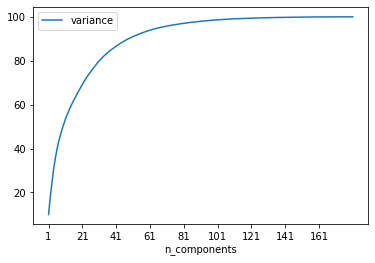

In [14]:
pca.fit(X_preprocessed)
pd.DataFrame({
    'n_components': range(1, len(X_preprocessed.columns) + 1),
    'variance': np.cumsum(pca.explained_variance_ratio_)*100         
    }).set_index('n_components').plot(xticks=range(1, X_preprocessed.shape[1], 20))

In [65]:
param_grid = {
    'preprocessor__cols': [iter4_cols],
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['cap', 'drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()],
    'preprocessor__transformer__cat__imputer': [SimpleImputer(strategy='constant', fill_value='missing')],
    'preprocessor__transformer__cat__ohe': [
        OneHotEncoder(drop='first', sparse=False), 
        OneHotEncoder(drop='if_binary', sparse=False)],
    'pca__n_components': [60, 80, 110],
    'clf__estimator': [LogisticRegression(), SVC(), XGBClassifier()],
}

In [67]:
logger.info('Starting Auto ML pipe...')
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=3, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results5 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()

2021-06-19 22:52:07,436 - INFO - Starting Auto ML pipe...


Fitting 3 folds for each of 64 candidates, totalling 192 fits


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.77900288 0.77926382 0.7795248  0.77913331 0.77985115 0.77991638
 0.78011214 0.78030791 0.7808298  0.78109082 0.78109083 0.78069933
 0.7808951  0.78122128 0.78096033 0.78089509 0.7706513  0.77195641
 0.77228216 0.77123848 0.77143422 0.76869353 0.7716951  0.76797591
 0.77221718 0.76882403 0.76980295 0.76882409 0.76862842 0.77065123
 0.76647513 0.76823679 0.79022581 0.79009534 0.78996485 0.79009532
 0.790813   0.79061727 0.79055201 0.790813   0.79126975 0.79140024
 0.7915307  0.79153074 0.79192213 0.79185689 0.79179164 0.79205262
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]
  category=UserWarning
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: U

In [68]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-19 23:02:50,157 - INFO - Best estimator score:
2021-06-19 23:02:54,322 - INFO - 0.7917536534446764


In [69]:
logger.info('Best estimator params:')
logger.info(gs.best_params_)

2021-06-19 23:02:54,332 - INFO - Best estimator params:
2021-06-19 23:02:54,334 - INFO - {'clf__estimator': SVC(), 'pca__n_components': 110, 'preprocessor__cols': ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'experiencia_relevante', 'nivel_educacion', 'educacion', 'experiencia', 'tamano_compania', 'tipo_compania', 'ultimo_nuevo_trabajo', 'horas_formacion'), 'preprocessor__transformer__cat__imputer': SimpleImputer(fill_value='missing', strategy='constant'), 'preprocessor__transformer__cat__ohe': OneHotEncoder(drop='if_binary', sparse=False), 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 'preprocessor__transformer__num__outliers__method': 'drop', 'preprocessor__transformer__num__scaler': MinMaxScaler()}


In [70]:
results4[:5]

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_pca__n_components,param_preprocessor__cols,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,47,7.941705,0.287740,4.812984,1.939164,SVC(),110,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,0.791936,0.790525,0.792053,0.001298,1,0.820789,0.824019,0.824427,0.823078,0.001627
1,44,8.025524,0.064713,3.850027,0.300588,SVC(),110,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",...,0.791740,0.790525,0.791922,0.001222,2,0.820593,0.824019,0.824134,0.822915,0.001643
2,45,7.691130,0.038201,3.531464,0.038335,SVC(),110,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",...,0.791544,0.790525,0.791857,0.001235,3,0.820985,0.823529,0.824427,0.822981,0.001458
3,46,7.761180,0.085413,3.583268,0.110864,SVC(),110,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,0.791349,0.790525,0.791792,0.001255,4,0.820789,0.823823,0.824427,0.823013,0.001592
4,43,6.650441,0.074239,3.032455,0.024804,SVC(),80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,0.790761,0.791699,0.791531,0.000572,5,0.815699,0.817755,0.819534,0.817663,0.001567


In [76]:
results4[[
    'param_clf__estimator',
    'param_preprocessor__transformer__num__outliers__method', 
    'param_preprocessor__transformer__cat__imputer',
    'param_preprocessor__transformer__cat__ohe',
    'param_pca__n_components',
    'mean_test_score']][:50]

,param_clf__estimator,param_preprocessor__transformer__num__outliers__method,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,param_pca__n_components,mean_test_score
0,SVC(),drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",110,0.792053
1,SVC(),cap,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",110,0.791922
2,SVC(),drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",110,0.791857
3,SVC(),cap,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",110,0.791792
4,SVC(),drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",80,0.791531
5,SVC(),cap,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",80,0.791531
6,SVC(),drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",80,0.791400
7,SVC(),cap,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",80,0.791270
8,SVC(),drop,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",60,0.790813
9,SVC(),cap,"SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",60,0.790813


### Iteración 5

In [14]:
from collections import Counter

iter5_cols = ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'experiencia_relevante', 'nivel_educacion', 'educacion', 'experiencia', 'tamano_compania', 'tipo_compania', 'ultimo_nuevo_trabajo', 'horas_formacion')

counter = Counter(y_train)
total_negative_examples, total_positive_examples = counter[0], counter[1]

In [17]:
param_grid = [{
    'clf__estimator': [LogisticRegression()], 
    'pca__n_components': [80], 
    'preprocessor__cols': [iter5_cols], 
    'preprocessor__transformer__cat__imputer': [SimpleImputer(fill_value='missing', strategy='constant')], 
    'preprocessor__transformer__cat__ohe': [OneHotEncoder(handle_unknown='ignore', sparse=False)], 
    'preprocessor__transformer__num__imputer': [SimpleImputer()], 
    'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 
    'preprocessor__transformer__num__outliers__method': ['drop'], 
    'preprocessor__transformer__num__scaler': [MinMaxScaler()]
}, {
    'clf__estimator': [RandomForestClassifier()],
    'preprocessor__cols': [iter5_cols],
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['cap'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()],
    'preprocessor__transformer__cat__imputer': [SimpleImputer(strategy='constant', fill_value='missing')],
    'preprocessor__transformer__cat__ohe': [OneHotEncoder(handle_unknown='ignore', sparse=False)],
    'pca__n_components': [75],
    'clf__estimator__random_state': [RANDOM_STATE],
    'clf__estimator__criterion': ['entropy'],
    'clf__estimator__min_samples_split': [4],
    'clf__estimator__n_estimators': [100],
    'clf__estimator__max_depth': [None, 6],
    'clf__estimator__min_samples_leaf': [2],
    'clf__estimator__max_features': [None],
    'clf__estimator__max_leaf_nodes': [25],
    'clf__estimator__max_samples': [None]
},{
    'preprocessor__cols': [iter5_cols],
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()],
    'preprocessor__transformer__cat__imputer': [SimpleImputer(strategy='constant', fill_value='missing')],
    'preprocessor__transformer__cat__ohe': [OneHotEncoder(drop='first', sparse=False)],
    'pca__n_components': [80],
    'clf__estimator': [SVC()],
    'clf__estimator__random_state': [RANDOM_STATE],
    'clf__estimator__kernel': ['rbf'],
    'clf__estimator__gamma': ['auto'],
    'clf__estimator__C': [100],
}, {    
    'preprocessor__cols': [iter5_cols],
    'preprocessor__transformer__num__outliers__exclude_cols': [['indice_desarrollo_ciudad']],
    'preprocessor__transformer__num__outliers__method': ['cap', 'drop'],
    'preprocessor__transformer__num__scaler': [MinMaxScaler()],
    'preprocessor__transformer__cat__imputer': [SimpleImputer(strategy='constant', fill_value='missing')],
    'preprocessor__transformer__cat__ohe': [
        OneHotEncoder(drop='first', sparse=False), 
        OneHotEncoder(drop='if_binary', sparse=False)],
    'pca__n_components': [80, 110],
    'clf__estimator': [XGBClassifier()],
    'clf__estimator__seed': [RANDOM_STATE],
    'clf__estimator__objective': ['binary:logistic'],
    'clf__estimator__scale_pos_weight': [round(total_negative_examples / total_positive_examples)],
    'clf__estimator__min_child_weight': [1, 2, 3],
    'clf__estimator__learning_rate': [0.1, 0.01, 0.05],
    'clf__estimator__n_estimators': range(60, 180, 40),
    'clf__estimator__max_delta_step': range(0, 3),
    'clf__estimator__eval_metric': ['auc'],
    'clf__estimator__use_label_encoder': [False],
    }]

In [ ]:
logger.info('Starting Auto ML pipe...')
auto_ml_pipe = make_pipeline(Preprocessor(), PCA(), Clf())
gs = GridSearchCV(auto_ml_pipe, param_grid, cv=2, n_jobs=-1, verbose=3, scoring='accuracy', return_train_score=True)
gs.fit(X_train, y_train)
results5 = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()

2021-06-23 11:29:29,078 - INFO - Starting Auto ML pipe...


Fitting 2 folds for each of 652 candidates, totalling 1304 fits


In [19]:
logger.info('Best estimator score:')
logger.info(gs.best_estimator_.score(X_test, y_test))

2021-06-23 07:48:00,102 - INFO - Best estimator score:
2021-06-23 07:48:03,727 - INFO - 0.7927974947807933


In [20]:
logger.info('Best estimator params:')
logger.info(gs.best_params_)

2021-06-23 07:48:03,735 - INFO - Best estimator params:
2021-06-23 07:48:03,736 - INFO - {'clf__estimator': SVC(C=100, gamma='auto', random_state=288), 'clf__estimator__C': 100, 'clf__estimator__gamma': 'auto', 'clf__estimator__kernel': 'rbf', 'clf__estimator__random_state': 288, 'pca__n_components': 80, 'preprocessor__cols': ('ciudad', 'indice_desarrollo_ciudad', 'genero', 'experiencia_relevante', 'nivel_educacion', 'educacion', 'experiencia', 'tamano_compania', 'tipo_compania', 'ultimo_nuevo_trabajo', 'horas_formacion'), 'preprocessor__transformer__cat__imputer': SimpleImputer(fill_value='missing', strategy='constant'), 'preprocessor__transformer__cat__ohe': OneHotEncoder(drop='first', sparse=False), 'preprocessor__transformer__num__outliers__exclude_cols': ['indice_desarrollo_ciudad'], 'preprocessor__transformer__num__outliers__method': 'drop', 'preprocessor__transformer__num__scaler': MinMaxScaler()}


In [21]:
results5

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_pca__n_components,param_preprocessor__cols,param_preprocessor__transformer__cat__imputer,param_preprocessor__transformer__cat__ohe,...,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,3,7.741516,0.271529,3.133198,0.006642,"SVC(C=100, gamma='auto', random_state=288)",80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",...,"{'clf__estimator': SVC(C=100, gamma='auto', ra...",0.791857,0.794075,0.792966,0.001109,1,0.804254,0.806734,0.805494,0.001240
1,0,0.598325,0.008383,0.082959,0.002217,LogisticRegression(),80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",...,"{'clf__estimator': LogisticRegression(), 'pca_...",0.782331,0.783244,0.782787,0.000457,2,0.783375,0.784419,0.783897,0.000522
2,1,52.479608,0.503159,0.177641,0.000909,RandomForestClassifier(),75,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",...,"{'clf__estimator': RandomForestClassifier(), '...",0.779982,0.781548,0.780765,0.000783,3,0.809083,0.800861,0.804972,0.004111
3,2,45.865952,0.084929,0.170522,0.003913,RandomForestClassifier(),75,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(handle_unknown='ignore', sparse=...",...,"{'clf__estimator': RandomForestClassifier(), '...",0.778807,0.781548,0.780177,0.001370,4,0.812215,0.804646,0.808430,0.003784
4,1296,1.177896,0.000078,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",110,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",...,{'clf__estimator': XGBClassifier(base_score=No...,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943,644,0.989437,0.130109,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='first', sparse=False)",...,{'clf__estimator': XGBClassifier(base_score=No...,NaN,NaN,NaN,NaN,1944,NaN,NaN,NaN,NaN
1944,643,1.223436,0.054061,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",110,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,{'clf__estimator': XGBClassifier(base_score=No...,NaN,NaN,NaN,NaN,1945,NaN,NaN,NaN,NaN
1945,642,1.209621,0.009475,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",110,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,{'clf__estimator': XGBClassifier(base_score=No...,NaN,NaN,NaN,NaN,1946,NaN,NaN,NaN,NaN
1946,670,1.174909,0.024147,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",80,"(ciudad, indice_desarrollo_ciudad, genero, exp...","SimpleImputer(fill_value='missing', strategy='...","OneHotEncoder(drop='if_binary', sparse=False)",...,{'clf__estimator': XGBClassifier(base_score=No...,NaN,NaN,NaN,NaN,1947,NaN,NaN,NaN,NaN


In [ ]:
results5[[
    'param_preprocessor__transformer__num__outliers__method',
    'param_preprocessor__transformer__cat__ohe',
    'param_pca__n_components',
    'param_clf__estimator',
    'mean_test_score']][:50]

3.0078451882845187